## Baseline for Slot1

## Check dataset existence

In [29]:
# check data existence
from pathlib import Path


data_folder = Path.cwd().parent.joinpath("data/processed")

def check_data_existence(folder):
    file_count = len(list(folder.glob("e*_ann.json")))
    if  file_count == 0:
        raise Exception("Processed Data does not exist.")
    else:
        print("{} files exist.".format(file_count))


check_data_existence(data_folder)

230 files exist.


## Read Slot1 data to DataFrame

* At the Slot1, from sentence predict E#A labels
* It is multi-class problem, and its evaluation is used [micro-averaging](http://www.aclweb.org/anthology/S16-1002)
* Duplicate label  occurrences are ignored. 

In [30]:
label_kinds = []

# make labels (exclude NULL and OOD)
for e in ["market", "company", "business", "product"]:
    for a in ["general", "sales", "profit", "amount", "price", "cost"]:
        label_kinds.append(e + "#" + a)
        if e in ["market"]:
            break;

print(label_kinds)

['market#general', 'company#general', 'company#sales', 'company#profit', 'company#amount', 'company#price', 'company#cost', 'business#general', 'business#sales', 'business#profit', 'business#amount', 'business#price', 'business#cost', 'product#general', 'product#sales', 'product#profit', 'product#amount', 'product#price', 'product#cost']


In [31]:
# Slot1 predicts E#A label from entity and sentence
import json
import pandas as pd
from collections import Counter
from janome.tokenizer import Tokenizer


sentences = []
labels = []
word_freq = Counter()
tokenizer = Tokenizer()
PAD = "__PAD__"
UNK = "__UNK__"


def format_word(word):
    if word.isdigit():
        return "0"
    else:
        return word.strip()


def tokenize(sentence, register=True):
    tokens = tokenizer.tokenize(sentence)
    words = []
    for t in tokens:
        pos = t.part_of_speech.split(",")
        if pos[0] == "名詞" or pos[1].startswith("括弧"):
            w = format_word(t.surface) 
            if w:
                words.append(w)
                if register:
                    word_freq[w] += 1
    return words
    

for f in data_folder.glob("e*_ann.json"):
    with f.open(encoding="utf-8") as j:
        d = json.load(j)
        for s in d["sentences"]:
            # register words
            tokenized = tokenize(s["sentence"])
            annotations = [o["category"] for o in s["opinions"]]
            
            if len(annotations) > 0:
                row = {}
                for k in label_kinds:
                    if k in annotations:
                        row[k] = 1
                    else:
                        row[k] = 0

                labels.append(row)
                sentences.append(tokenized)


labels = pd.DataFrame(labels)
labels.head(5)

,business#amount,business#cost,business#general,business#price,business#profit,business#sales,company#amount,company#cost,company#general,company#price,company#profit,company#sales,market#general,product#amount,product#cost,product#general,product#price,product#profit,product#sales
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
%matplotlib inline

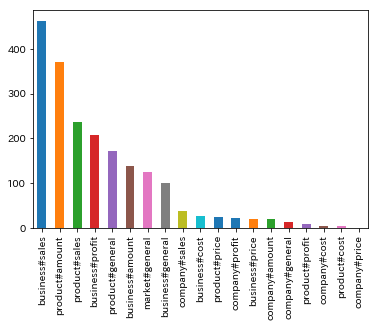

In [33]:
labels.sum(axis=0).sort_values(ascending=False).plot.bar()

In [34]:
if len(sentences) != len(labels):
    raise Exception("sentence and label count does not match!")

print("{} data is available.".format(len(labels)))

3215 data is available.


In [35]:
vocab = [PAD, UNK]
max_vocab = 5000

for term, freq in word_freq.most_common():
    if len(vocab) < max_vocab:
        vocab.append(term)
        
print("Vocabulary size is {} / {}.".format(len(vocab), len(word_freq)))

Vocabulary size is 5000 / 7365.


## Make Baseline Model

* Baseline Model predicts E#A labels from TF/IDF.


In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


class SentenceTfidf(BaseEstimator, TransformerMixin):
    
    def __init__(self, corpus, vocab):
        # corpus includes train/test sentences
        # fit is executed under train data indices, and tranform is done under test ones.
        self.corpus = corpus
        self.vocab = vocab
        self.vectorizer = TfidfVectorizer(vocabulary=self.vocab)
    
    def fit(self, X, y=None):
        indices = X.flatten()
        texts = [self._format_text(i) for i in indices]
        self.vectorizer.fit(texts)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    
    def _format_text(self, i):
        s = self.corpus[i]
        s = [UNK if w not in vocab else w for w in s]
        text = " ".join(s)
        return text

    def transform(self, X, copy=True):
        indices = X.flatten()
        texts = [self._format_text(i) for i in indices]
        return self.vectorizer.transform(texts, copy)


model = Pipeline([("vectorize", SentenceTfidf(sentences, vocab)), ("clf", OneVsRestClassifier(LinearSVC(random_state=0)))])

## Train the Model

(3215, 1)
(3215, 19)
[learning_curve] Training set sizes: [ 257  835 1414 1993 2572]
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))


[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   0.5s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   1.2s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   1.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.3s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:    3.9s remaining:    3.9s
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   1.3s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
[Parallel(n_jobs=4)]: Done   6 out of  11 | elapsed:    5.3s remaining:    4.4s


[CV] ................................................. , total=   3.4s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=4)]: Done   7 out of  14 | elapsed:    6.3s remaining:    6.3s
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
/Us

[CV] ................................................. , total=   0.7s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   1.4s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn

[CV] ................................................. , total=   0.6s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   1.8s


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV]  ................................................................
[CV] ................................................. , total=   2.7s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.6s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 17 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn

[CV] ................................................. , total=   0.6s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   1.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   3.2s
[CV] ................................................. , total=   1.4s


/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ................................................. , total=   1.6s
[CV] ................................................. , total=   1.8s


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   17.8s finished


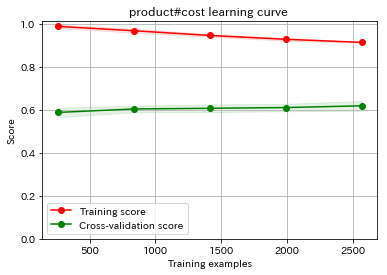

In [46]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit


# learning curve function
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
        estimator, title, X, y, ylim=None, cv=None,
        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

X = np.array(list(range(len(sentences)))).reshape((-1, 1))
print(X.shape)
print(labels.shape)
plot_learning_curve(model, "{} learning curve ".format(k), 
                                     X, labels, ylim=(0.0, 1.01), cv=cv, n_jobs=4, verbose=2)

plt.show()

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

f1 = []
for train_index, test_index in cv.split(X):
    model.fit(X[train_index, :], labels.iloc[train_index, :])
    y_pred = model.predict(X[test_index, :])
    y_true = labels.iloc[test_index, :]
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    f1.append(micro_f1)

print("F1 is {} (+/-{})".format(np.mean(f1), np.std(f1)))

/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/m

F1 is 0.32125263148294236 (+/-0.02006451414950943)
